In [55]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import multilabel_confusion_matrix,classification_report,hamming_loss, f1_score
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import seaborn as sns

In [3]:
# resize with keeping ratio
def resize_with_padding(img, target_size):
    h, w = img.shape[:2]
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h))
    result = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    x_offset = (target_size - new_w) // 2
    y_offset = (target_size - new_h) // 2
    result[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return result

In [35]:
def lbp_histogram(gray, P=16, R=2, method='ror'):
    lbp = local_binary_pattern(gray, P=P, R=R, method=method)
    hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0, 59))
    hist = hist.astype('float32')
    hist = hist / (hist.sum() + 1e-8)
    return hist

In [36]:
def color_hist(img, bins=16):
    hist_b = cv2.calcHist([img], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [bins], [0, 256])
    hist = np.concatenate([hist_b, hist_g, hist_r]).ravel()
    hist = hist / (hist.sum() + 1e-8)
    return hist

In [37]:
def plot_mcm_heatmaps(y_true, y_pred, class_names):
    colors = ['Blues', 'Greens','RdPu','summer','viridis']
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    n_plots = len(class_names)
    cols = 3
    rows = int(np.ceil(n_plots / cols))

    plt.figure(figsize=(10,rows*cols))
    for i, name in enumerate(class_names):
        plt.subplot(rows, cols, i + 1)
        sns.heatmap(
            mcm[i],
            annot=True,
            fmt="d",
            cmap=colors[i],
            cbar=False,
            linewidths=1,
            linecolor="black",
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.xticks([0.5, 1.5], ["0", "1"])
        plt.yticks([0.5, 1.5], ["0", "1"])
        plt.title(name)


    plt.tight_layout()
    plt.show()

In [38]:
def extract_hog(gray,cell=(8,8),block=(2,2),norm='L2-Hys'):
    return hog(gray, orientations=9, pixels_per_cell=cell, cells_per_block=block, block_norm=norm)

In [8]:
with open(f'data/train/_annotations.coco.json') as f:
    train = json.load(f)
print(train.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [9]:
train_images = train['images']
train_labels = pd.DataFrame(train['annotations'])
categories = train['categories']
len(train_images) , len(train_labels)

(2571, 4044)

In [10]:
categories

[{'id': 0, 'name': 'Recycling-Waste', 'supercategory': 'none'},
 {'id': 1, 'name': 'cardboard', 'supercategory': 'Recycling-Waste'},
 {'id': 2, 'name': 'glass', 'supercategory': 'Recycling-Waste'},
 {'id': 3, 'name': 'metal', 'supercategory': 'Recycling-Waste'},
 {'id': 4, 'name': 'paper', 'supercategory': 'Recycling-Waste'},
 {'id': 5, 'name': 'plastic', 'supercategory': 'Recycling-Waste'}]

In [11]:
train_images[:1]

[{'id': 0,
  'license': 1,
  'file_name': 'metal152_jpg.rf.06414376028f03cc3a360e50505abb0f.jpg',
  'height': 384,
  'width': 512,
  'date_captured': '2025-11-30T15:32:11+00:00',
  'extra': {'name': 'metal152.jpg'}}]

In [12]:
train_labels[:1]

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,1,0,3,"[172, 152, 114, 93]",10602,[],0


In [13]:
train_labels.groupby('image_id').size().sort_values()

image_id
50       1
51       1
52       1
53       1
54       1
        ..
573     11
532     11
1681    11
1693    11
2125    13
Length: 2571, dtype: int64

In [14]:
train_labels.groupby('category_id').size().sort_values()

category_id
1     630
4     683
2     726
3     916
5    1089
dtype: int64

In [39]:
def make_x_y(part,target_size=128,cell=(8,8),block=(2,2),norm='L2-Hys',bins=16,p=16,r=2,method='ror'):
    with open(f'data/{part}/_annotations.coco.json') as f:
        data = json.load(f)

    images = data['images']
    labels = pd.DataFrame(data['annotations'])

    labels_per_image = labels.groupby("image_id")["category_id"].apply(lambda x: sorted(set(x)))

    mlb = MultiLabelBinarizer(classes=[1,2,3,4,5])
    binary_labels = mlb.fit_transform(labels_per_image)

    y_data = pd.DataFrame(binary_labels, index=labels_per_image.index, columns=mlb.classes_)
    
    X_hog = []
    X_lbp = []
    X_color_hist = []

    for image in images:
        img = cv2.imread(f'data/{part}/{image["file_name"]}')
        img = resize_with_padding(img, target_size)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # normal_gray = cv2.normalize(gray.astype("float32"), None, alpha=0, beta=1,
        #                     norm_type=cv2.NORM_MINMAX)
        X_hog.append(extract_hog(gray,cell,block,norm))
        X_lbp.append(lbp_histogram(gray,p,r,method))
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        X_color_hist.append(color_hist(lab,bins))

    X_hog = np.array(X_hog)
    X_lbp = np.array(X_lbp)
    X_color_hist = np.array(X_color_hist)

    return X_hog, X_lbp, X_color_hist, y_data

In [16]:
def svc_predict(X, y, X_test):
    base_svc = SVC()
    multi_clf = MultiOutputClassifier(base_svc)

    param_grid = {
        "estimator__kernel": ["rbf", "poly", "sigmoid", "linear"],
        "estimator__C": [0.1, 1, 10],
        "estimator__gamma": ["scale", "auto", 0.01],
        "estimator__degree": [2, 3],
    }

    grid = GridSearchCV(
        estimator=multi_clf,
        param_grid=param_grid,
        scoring="f1_micro",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X, y)  
    y_pred = grid.predict(X_test)
    return y_pred


In [46]:
def combine(targetsize=128,cell=(8,8),block=(2,2),norm='L2-Hys',bins=16,p=16,r=2,method='ror'):
    X_hog_train, X_lbp_train, X_color_train, y_train = make_x_y('train', targetsize,cell,block,norm,bins,p,r,method)
    X_hog_valid, X_lbp_valid, X_color_valid, y_valid= make_x_y('valid', targetsize,cell,block,norm,bins,p,r,method)
    X_hog_test, X_lbp_test, X_color_test, y_test = make_x_y('test', targetsize,cell,block,norm,bins,p,r,method) 
    X_hog = np.vstack([X_hog_train, X_hog_valid, X_hog_test])
    X_lbp = np.vstack([X_lbp_train, X_lbp_valid, X_lbp_test])
    X_color = np.vstack([X_color_train, X_color_valid, X_color_test])
    y = pd.concat([y_train, y_valid, y_test], axis=0).reset_index(drop=True)
    X = np.hstack([X_hog, X_lbp, X_color])
    X_shuf, y_shuf = shuffle(X, y, random_state=7)
    X_np = np.array(X)
    y_np = np.array(y)
    X, y, X_test, y_test = iterative_train_test_split(X_np, y_np, test_size=0.2)
    return X, y, X_test, y_test

In [17]:
# validation_target_size = []
# sizes = [(128, True), (64, True), (64, False), (32, False), (16, False)]
# for target_size, use_pca in sizes:
#     X_hog_train, X_lbp_train, X_color_train, y_train = make_x_y('train', target_size)
#     X_hog_valid, X_lbp_valid, X_color_valid, y_valid= make_x_y('valid', target_size)
#     X_hog_test, X_lbp_test, X_color_test, y_test = make_x_y('test', target_size)
#     X_hog = np.vstack([X_hog_train, X_hog_valid])
#     X_lbp = np.vstack([X_lbp_train, X_lbp_valid])
#     X_color = np.vstack([X_color_train, X_color_valid])
#     y = pd.concat([y_train, y_valid], axis=0).reset_index(drop=True)
#     if use_pca:
#         pca = PCA(n_components=300, random_state=7)
#         X_hog_pca = pca.fit_transform(X_hog)
#         X_hog_test_pca = pca.transform(X_hog_test)
#         X = np.hstack([X_hog_pca, X_lbp, X_color])
#         X_test  = np.hstack([X_hog_test_pca, X_lbp_test, X_color_test])
#     else:
#         X = np.hstack([X_hog, X_lbp, X_color])
#         X_test  = np.hstack([X_hog_test, X_lbp_test, X_color_test])
#     y_pred = svc_predict(X, y, X_test)
#     validation_target_size.append((f1_score(y_test.values, y_pred, average='micro'),hamming_loss(y_test.values, y_pred)))

    
# index_labels = [f"{s}_{'PCA' if p else 'noPCA'}" for s, p in sizes]
# validation_target_size = pd.DataFrame(validation_target_size, index=index_labels, columns=['f1','hamming_loss'])

# validation_target_size

In [18]:
class_names = [cat['name'] for cat in categories[1:]]

In [19]:
X_hog_train, X_lbp_train, X_color_train, y_train = make_x_y('train', 128)
X_hog_valid, X_lbp_valid, X_color_valid, y_valid= make_x_y('valid',128)
X_hog_test, X_lbp_test, X_color_test, y_test = make_x_y('test',128) 

In [20]:
X_hog_train.shape, y_train.shape, X_hog_valid.shape, y_valid.shape

((2571, 8100), (2571, 5), (973, 8100), (973, 5))

In [21]:
X_hog = np.vstack([X_hog_train, X_hog_valid, X_hog_test])
X_lbp = np.vstack([X_lbp_train, X_lbp_valid, X_lbp_test])
X_color = np.vstack([X_color_train, X_color_valid, X_color_test])
y = pd.concat([y_train, y_valid, y_test], axis=0).reset_index(drop=True)
X = np.hstack([X_hog, X_lbp, X_color])

In [22]:
# X_hog.shape, y.shape

In [23]:
X_shuf, y_shuf = shuffle(X, y, random_state=7)
X_np = np.array(X)
y_np = np.array(y)
X, y, X_test, y_test = iterative_train_test_split(X_np, y_np, test_size=0.2)


In [24]:
X.shape, X_test.shape

((2931, 8207), (742, 8207))

In [25]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=200,random_state=7)),
    ("clf", MultiOutputClassifier(SVC(probability=True, class_weight="balanced")))
    ]) 
pipe.fit(X, y)
probs_list  = pipe.predict_proba(X_test)
probs = np.column_stack([p[:, 1] for p in probs_list]) 
y_pred = (probs > 0.35).astype(int)

print(y_pred.shape)
print(hamming_loss(y_test, y_pred))
print(classification_report(y_test, y_pred))

(742, 5)
0.15444743935309974
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       175
           1       0.66      0.69      0.67       170
           2       0.73      0.62      0.67       191
           3       0.73      0.72      0.73       177
           4       0.63      0.78      0.70       249

   micro avg       0.70      0.72      0.71       962
   macro avg       0.71      0.71      0.71       962
weighted avg       0.70      0.72      0.71       962
 samples avg       0.61      0.68      0.63       962



c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


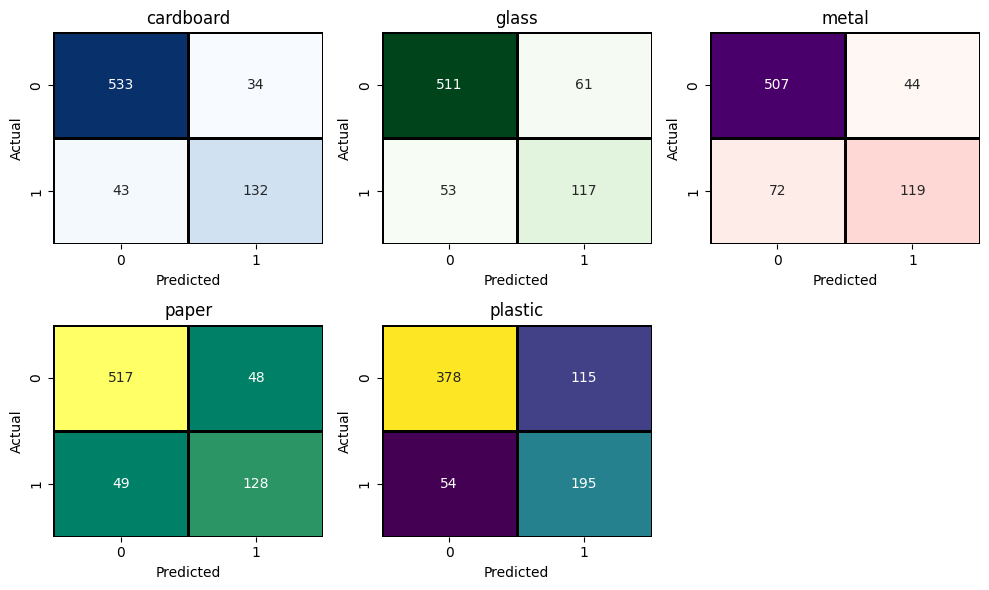

In [26]:
plot_mcm_heatmaps(y_test, y_pred, class_names)

In [27]:
base_svc = SVC(probability=True, class_weight="balanced")
pipe_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=7)),
    ("clf", MultiOutputClassifier(base_svc))
])

param_grid_svc = {
    "pca__n_components": [150, 200, 250, 300, 350, 400],

    "clf__estimator__kernel": ["rbf"],
    "clf__estimator__C": [0.01, 0.1, 1, 10, 100],
    "clf__estimator__gamma": ["scale", "auto"],
    "clf__estimator__class_weight": ["balanced"],
}

grid_svc = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid_svc,
    scoring="f1_micro",
    cv=5,
    n_jobs=-1
)

grid_svc.fit(X, y)

print("Best params:", grid_svc.best_params_)
best_pipe_svc = grid_svc.best_estimator_


Best params: {'clf__estimator__C': 1, 'clf__estimator__class_weight': 'balanced', 'clf__estimator__gamma': 'scale', 'clf__estimator__kernel': 'rbf', 'pca__n_components': 150}


0.15902964959568733
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       175
           1       0.64      0.69      0.66       170
           2       0.74      0.63      0.68       191
           3       0.70      0.71      0.70       177
           4       0.63      0.79      0.70       249

   micro avg       0.69      0.71      0.70       962
   macro avg       0.70      0.71      0.70       962
weighted avg       0.69      0.71      0.70       962
 samples avg       0.60      0.67      0.62       962



c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


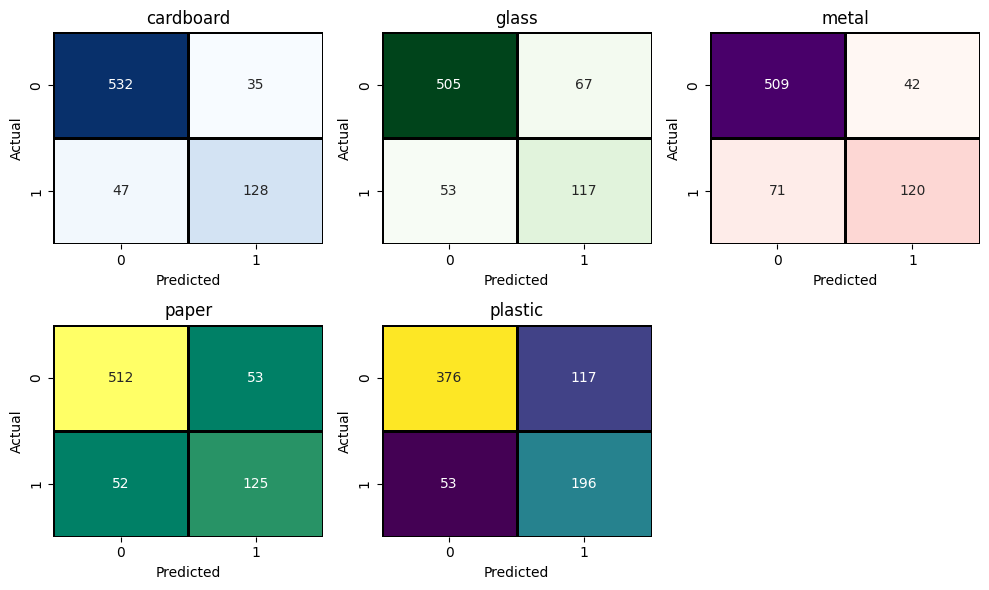

In [28]:
probs_list_svc = best_pipe_svc.predict_proba(X_test)
probs_svc = np.column_stack([p[:, 1] for p in probs_list_svc])

y_pred_svc = (probs_svc > 0.35).astype(int)

print(hamming_loss(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))
plot_mcm_heatmaps(y_test, y_pred_svc, class_names)

In [29]:
base_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False
)

pipe_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=7)),
    ("clf", MultiOutputClassifier(base_xgb))
])

param_grid_xgb = {
    "pca__n_components": [150, 200, 250, 300, 350, 400],

    "clf__estimator__n_estimators": [100, 200],
    "clf__estimator__max_depth": [3, 5, 7],
    "clf__estimator__learning_rate": [0.01, 0.1, 0.2],
    "clf__estimator__subsample": [0.7, 1.0],
    "clf__estimator__colsample_bytree": [0.7, 1.0],
}

grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    scoring="f1_micro",
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X, y)
y_pred_xgb = grid_xgb.predict(X_test)

c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:57:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:57:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:57:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:57:22] WARNING: C:\a

0.17169811320754716
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       175
           1       0.76      0.34      0.47       170
           2       0.90      0.36      0.51       191
           3       0.87      0.42      0.56       177
           4       0.70      0.43      0.53       249

   micro avg       0.82      0.43      0.57       962
   macro avg       0.83      0.43      0.57       962
weighted avg       0.82      0.43      0.56       962
 samples avg       0.38      0.36      0.36       962



c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


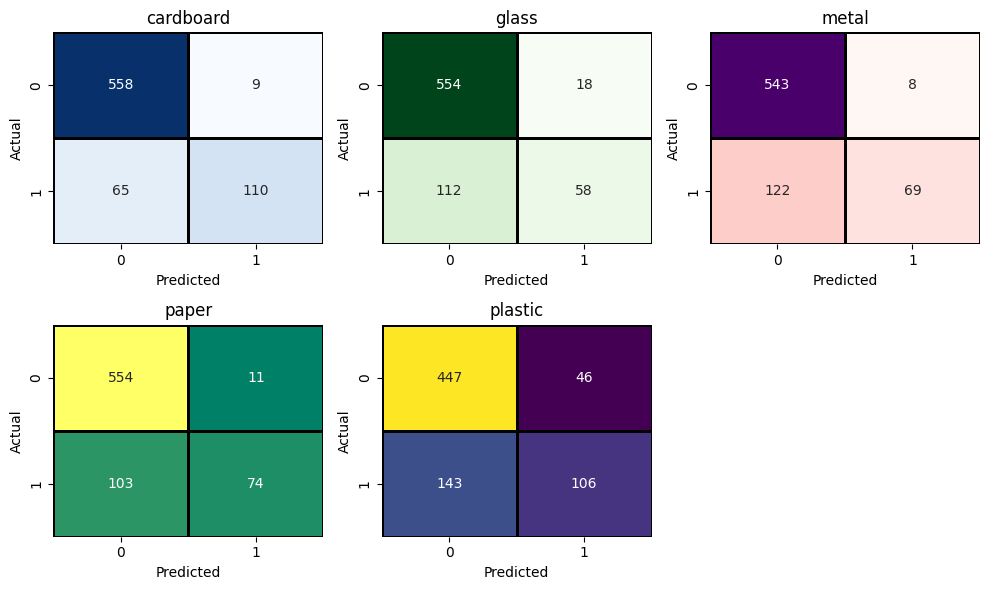

In [30]:
print(hamming_loss(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
plot_mcm_heatmaps(y_test, y_pred_xgb, class_names)

In [31]:
base_log = LogisticRegression()

pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=7)),
    ("clf", MultiOutputClassifier(base_log))
])

param_grid_log = {
    "pca__n_components": [150, 200, 250, 300, 350, 400],

    "clf__estimator__C": [0.01, 0.1, 1, 10, 100],
    "clf__estimator__solver": ["lbfgs", "saga"],
    "clf__estimator__class_weight": [None, "balanced"],
    "clf__estimator__penalty": ["l2"],
    "clf__estimator__max_iter": [200, 500, 1000]
}


grid_log = GridSearchCV(
    estimator=pipe_log,
    param_grid=param_grid_log,
    scoring="f1_micro",
    cv=5,
    n_jobs=-1
)

grid_log.fit(X, y)
y_pred_log = grid_log.predict(X_test)

c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.21536388140161725
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       175
           1       0.45      0.56      0.50       170
           2       0.54      0.64      0.59       191
           3       0.62      0.68      0.65       177
           4       0.56      0.65      0.60       249

   micro avg       0.57      0.66      0.61       962
   macro avg       0.58      0.66      0.62       962
weighted avg       0.58      0.66      0.62       962
 samples avg       0.50      0.62      0.54       962



c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


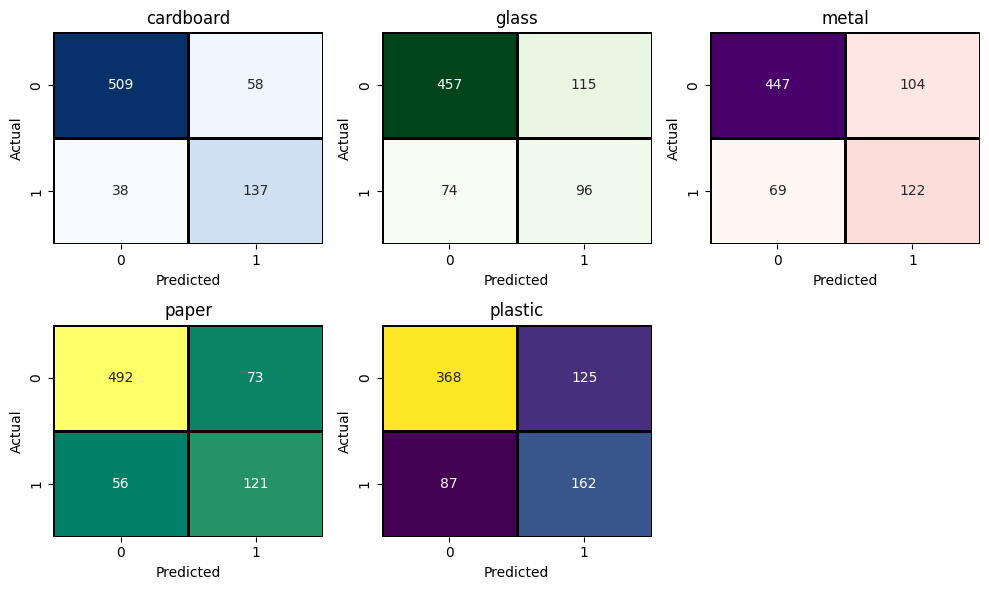

In [32]:
print(hamming_loss(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
plot_mcm_heatmaps(y_test, y_pred_log, class_names)

In [48]:
X_low_D, y_low_D,X_test_low_D,y_test_low_D=combine(
    targetsize=128,
    cell=(16,16),
    block=(2,2),
    norm='L2-Hys',
    bins=16,
    p=8,
    r=1,
    method='uniform'
)

In [49]:
base_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1
)

pipe_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", OneVsRestClassifier(base_xgb))
])

param_grid_xgb = {
    "clf__estimator__n_estimators": [100, 200],
    "clf__estimator__max_depth": [3, 4, 5],
    "clf__estimator__learning_rate": [0.05, 0.1],
    "clf__estimator__subsample": [0.7, 1.0],
    "clf__estimator__colsample_bytree": [0.7, 1.0],
}

grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    scoring="f1_micro",
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X_low_D, y_low_D)
y_pred_xgb = grid_xgb.predict(X_test_low_D)


c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:56:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:56:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:57:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:57:28] WARNING: C:\a

0.10350404312668464
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       175
           1       0.89      0.57      0.70       170
           2       0.91      0.60      0.72       191
           3       0.91      0.68      0.78       177
           4       0.89      0.71      0.79       249

   micro avg       0.91      0.67      0.77       962
   macro avg       0.91      0.66      0.77       962
weighted avg       0.91      0.67      0.77       962
 samples avg       0.64      0.63      0.63       962



c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


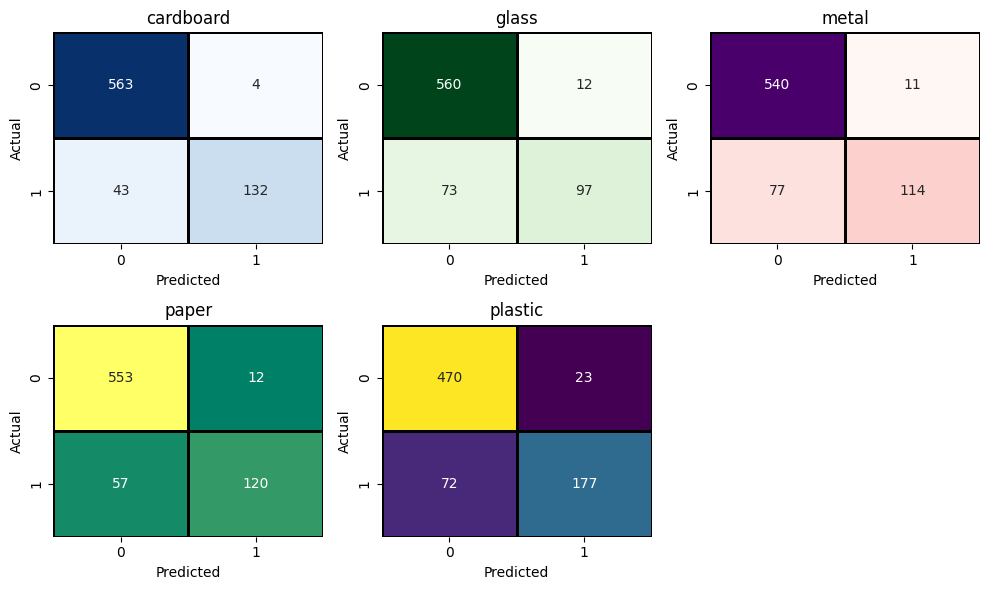

In [51]:
print(hamming_loss(y_test_low_D, y_pred_xgb))
print(classification_report(y_test_low_D, y_pred_xgb))
plot_mcm_heatmaps(y_test_low_D, y_pred_xgb, class_names)

In [ ]:
proba_xgb = grid_xgb.predict_proba(X_test_low_D)
y_pred_xgb_thresh = (proba_xgb >= 0.3).astype(int)

In [60]:
print(hamming_loss(y_test_low_D, y_pred_xgb_thresh))
print(classification_report(y_test_low_D, y_pred_xgb_thresh))

0.1
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       175
           1       0.81      0.68      0.74       170
           2       0.86      0.71      0.78       191
           3       0.86      0.74      0.80       177
           4       0.80      0.80      0.80       249

   micro avg       0.85      0.75      0.80       962
   macro avg       0.85      0.75      0.79       962
weighted avg       0.85      0.75      0.79       962
 samples avg       0.70      0.73      0.71       962



c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [56]:
base_lsvc = LinearSVC()

pipe_lsvc = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=7)),
    ("clf", OneVsRestClassifier(base_lsvc))
])

param_dist_lsvc = {
    "pca__n_components": [150, 200, 250, 300, 350, 400],

    "clf__estimator__C": np.logspace(-3, 2, 10),   # 0.001 → 100
    "clf__estimator__class_weight": [None, "balanced"],
    "clf__estimator__max_iter": [2000, 4000, 6000]
}

rand_lsvc = RandomizedSearchCV(
    estimator=pipe_lsvc,
    param_distributions=param_dist_lsvc,
    n_iter=20,
    scoring="f1_micro",
    cv=5,
    n_jobs=-1,
    random_state=7
)

rand_lsvc.fit(X, y)
y_pred_lsvc = rand_lsvc.predict(X_test)


0.23153638814016173
              precision    recall  f1-score   support

           0       0.64      0.79      0.71       175
           1       0.46      0.68      0.55       170
           2       0.52      0.65      0.58       191
           3       0.56      0.70      0.62       177
           4       0.54      0.69      0.61       249

   micro avg       0.54      0.70      0.61       962
   macro avg       0.54      0.70      0.61       962
weighted avg       0.54      0.70      0.61       962
 samples avg       0.49      0.66      0.55       962



c:\Users\davood\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


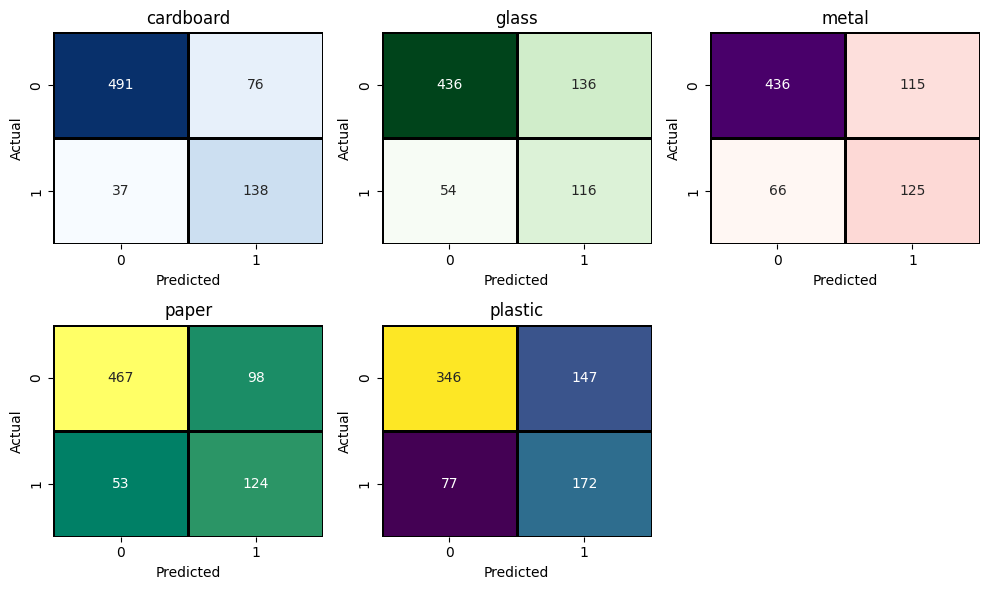

In [57]:
print(hamming_loss(y_test, y_pred_lsvc))
print(classification_report(y_test, y_pred_lsvc))
plot_mcm_heatmaps(y_test, y_pred_lsvc, class_names)